In [161]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1
from scipy.stats import norm


In [162]:
import uniswap_v3_liquidity_math as uniMath

In [163]:
# p = 1327
# a = 1101
# b = 1504
# y = 1000

# sp = p ** 0.5
# sa = a ** 0.5
# sb = b ** 0.5
# L = uniMath.get_liquidity_1(y, sa, sp)
# x = uniMath.calculate_x(L, sp, sa, sb)
# # print(uniMath.calculate_y(L, sp, sa, sb))
# # print(uniMath.calculate_y(L, sp, sa, sb))
# print('L:', L)
# print('eth:', x)
# print('usdc:', y)
# print('TV:', p*x + y)

In [164]:
# def uniswapV3_TV(S, priceUpper, priceLower):
#     K = np.sqrt(priceUpper*priceLower)
#     r = np.sqrt(priceUpper/priceLower)
    
#     return (2*np.sqrt(K*r*S) - K - S) / (r - 1)
    

In [165]:
def get_tokens_amounts(initial_price, lowerPrice, upperPrice, initial_y, currentPrice):
    sp = initial_price ** 0.5
    sa = lowerPrice ** 0.5
    sb = upperPrice ** 0.5
    current_sp = currentPrice ** 0.5
    L = uniMath.get_liquidity_1(initial_y, sa, sp)
    x = uniMath.calculate_x(L, current_sp, sa, sb)
    y = uniMath.calculate_y(L, current_sp, sa, sb)
    return (x, y)
    

In [201]:
def uniswapV3_TV(S, priceUpper, priceLower, initial_y, initial_price):
    x, y = get_tokens_amounts(initial_price=initial_price, lowerPrice=priceLower, upperPrice=priceUpper, initial_y=initial_y, currentPrice=S)
    
    return x * S + y
    

In [202]:
# get_tokens_amounts(initial_price=1330, lowerPrice=1100, upperPrice=1500, initial_y=1000, currentPrice=1300)



In [203]:
params = {'priceUpper': 2500, 'priceLower': 1100, 'current_price': 1300, 'y0': 300, 'T': 0.1, 'r': 0.1, 'sigma': 0.7}


In [204]:
priceUpper = params['priceUpper']
priceLower = params['priceLower']
current_price = params['current_price']

# initial_TV = params['x0'] * 2 # => we assume lowerPrice = current_price*0.5, upperPrice = current_price*2
y0 = params['y0']
T = params['T']
r = params['r']
sigma = params['sigma']


In [205]:
tokens_amounts = get_tokens_amounts(initial_price=current_price, 
                                    lowerPrice=priceLower, upperPrice=priceUpper, 
                                    initial_y=y0, currentPrice=current_price)


eth, usdc = tokens_amounts
print('tokens amounts:', eth, usdc)
print('initial TV:', eth*current_price + usdc)

tokens amounts: 0.8031464967658842 300.0
initial TV: 1344.0904457956494


In [206]:
lower_tick = get_tokens_amounts(initial_price=current_price, 
                                    lowerPrice=priceLower, upperPrice=priceUpper, 
                                    initial_y=y0, currentPrice=priceLower)
lower_tick = lower_tick[0]

In [207]:
upper_tick = get_tokens_amounts(initial_price=current_price, 
                                    lowerPrice=priceLower, upperPrice=priceUpper, 
                                    initial_y=y0, currentPrice=priceUpper)
upper_tick = upper_tick[1]

In [208]:
# initial_TV

In [209]:
# amount of option contracts to protect initial_TV

# amount = uniswapV3_TV(priceLower, priceUpper, priceLower) / priceLower



In [211]:
mid_prices = [price for price in range(priceLower, priceUpper, 1)]
low_prices = list(range(0, priceLower+10, 10))
high_prices = list(range(priceUpper, 2000, 10))
hodl_eth = [x * lower_tick for x in low_prices]
hodl_usdc = [upper_tick] * len(high_prices)
TVs = [uniswapV3_TV(price, priceUpper, priceLower, y0, current_price) for price in mid_prices]

In [212]:
N = norm.cdf

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

In [213]:
print(len(hodl_usdc), len(hodl_eth))

0 111


In [214]:
TVs[0]

1159.4210097448126

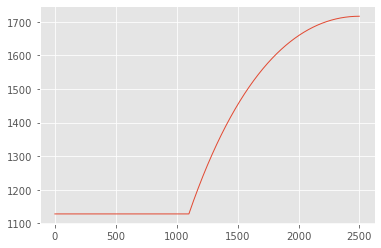

In [215]:
all_prices = low_prices + mid_prices + high_prices
TV1 = [TVs[0] - BS_PUT(current_price, priceLower, T, r, sigma) for price in low_prices]
TV2 = list(map(lambda x: x - BS_PUT(current_price, priceLower, T, r, sigma), hodl_usdc))
_TV = TV1 + list(map(lambda x: x - BS_PUT(current_price, priceLower, T, r, sigma), TVs)) + TV2
plt.plot(all_prices, _TV)
# plt.ylim(ymin=0, ymax=2000)

In [216]:
BS_PUT(1300, 1300, 0.1, r, 0.68) * 0.42

43.85046336935836

In [217]:
# np.array(hodl_usdc) + np.array(hodl_usdc)

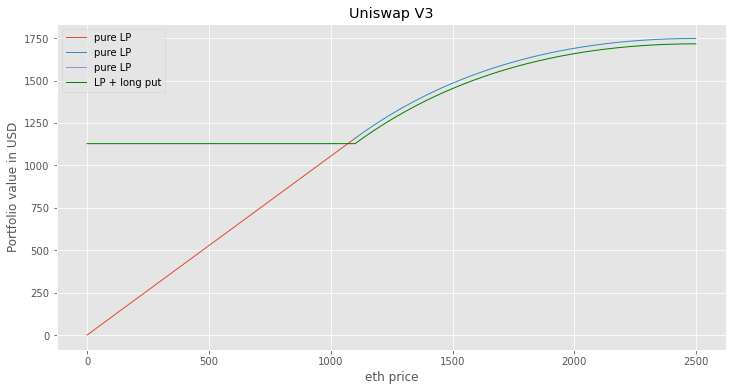

In [219]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
ax.plot(low_prices, hodl_eth)
ax.plot(mid_prices, TVs)
ax.plot(high_prices, hodl_usdc)
ax.plot(all_prices, _TV, 'g')
# ax.set_ylim(ymax=8000)
# ax.set_xlim(xmax=2000)
ax.set_title('Uniswap V3')
ax.set_xlabel('eth price')
ax.set_ylabel('Portfolio value in USD')
ax.legend(['pure LP', 'pure LP', 'pure LP', 'LP + long put'])

In [220]:
print(current_price)

1300


In [221]:
# tokens_amounts = get_tokens_amounts(initial_price=1330, 
#                                     lowerPrice=1100, upperPrice=1500, 
#                                     initial_y=1000, currentPrice=current_price)


# eth, usdc = tokens_amounts

In [222]:
eth

0.8031464967658842

In [223]:
K = current_price
S0 = current_price

In [224]:
put_payoffs = np.array([(max(0, K - price) - BS_PUT(S0, K, T, r, sigma)) * lower_tick for price in all_prices])

In [225]:
print(BS_PUT(S0, K, T, r, sigma)*lower_tick)

113.46178854894148


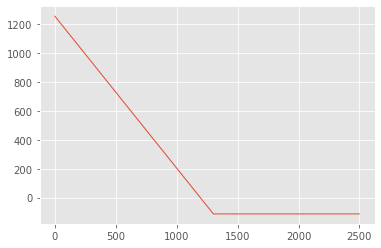

In [226]:
plt.plot(all_prices, put_payoffs)

In [227]:
LP_with_vanilla_put = np.array(hodl_eth + TVs + hodl_usdc) + put_payoffs
pure_LP = hodl_eth + TVs + hodl_usdc

In [228]:
usdc + eth * current_price # initial TV

1344.0904457956494

In [229]:
put_payoffs[10]

1151.3611311726722

### Suppose LP earns 5% monthly

In [230]:
def get_LP_fees(TV, T):
    return TV * 0.05 * (T / (30))

In [231]:
get_LP_fees(usdc + eth*current_price, 36)

80.64542674773897

In [232]:
LP_with_vanilla_put_with_fees = LP_with_vanilla_put + np.array([get_LP_fees(usdc+eth*current_price, T*365)] * len(LP_with_vanilla_put))




In [247]:
index_of_current_price = all_prices.index(current_price)

pure_LP_ATM = (pure_LP[index_of_current_price])
LPwvpwf_ATM = (LP_with_vanilla_put_with_fees[index_of_current_price])

print(index_of_current_price)
print(pure_LP_ATM, LPwvpwf_ATM)
print(1 - LPwvpwf_ATM/pure_LP_ATM)


311
1344.0904457956494 1312.3941593659433
0.02358195947962649


In [269]:
print('current eth price(i.e. initial price):', current_price)
print('break even:')
print('eth price:', all_prices[index_of_current_price+42])
print('TV:', LP_with_vanilla_put_with_fees[index_of_current_price+42])

current eth price(i.e. initial price): 1300
break even:
eth price: 1342
TV: 1345.1648650343843


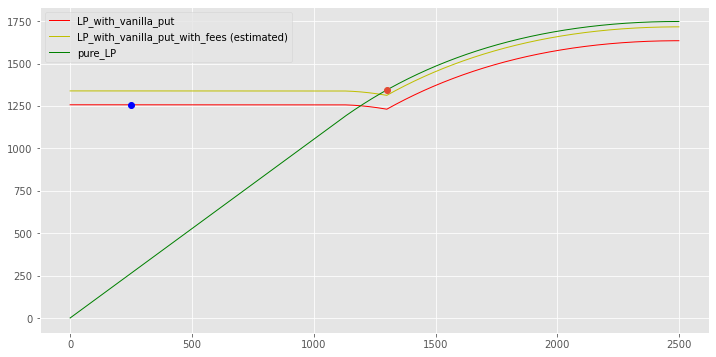

In [234]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)

ax.plot(all_prices, LP_with_vanilla_put, 'r')
ax.plot(all_prices, LP_with_vanilla_put_with_fees, 'y')
ax.plot(all_prices, pure_LP, 'g')
ax.plot([current_price], [usdc + eth * current_price], 'o')
ax.plot([250], [((max(0, K - 250) - BS_PUT(S0, K, T, r, sigma)) * lower_tick) + lower_tick * 250], 'bo')
# ax.set_ylim(ymin=400, ymax=1300)
ax.legend(['LP_with_vanilla_put', 'LP_with_vanilla_put_with_fees (estimated)', 'pure_LP'])